In [ ]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np

# Check PyTorch version

torch.__version__

'2.5.1+cu121'

## 1. Data (Preparing and Loading)

Data can be almost anything... in machine learning
* Excel speadsheet
* Images of any kind
* Videos (YouTube has lots of data...)
* Audio like songs or podcasts

Machine learning is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some *known* data using the linear regression formula.

We'll use a linear regression formula to make a straight line with known **parameters**.


In [ ]:
#Create *known* parameters
weight = 0.7
bias = 0.3

#Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Splitting data into training and test sets (one of the most important concepts in machine learning in general)

Let's create a training and test set with our data.

In [ ]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(X_test)

(40, 10)

How might we better visualize our data?

This is wheere the data explorer's motto comes in!

"Visualize, visualize, visualize!"

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="c", s=4, label="Training data")

  # Plot testing data in green
  plt.scatter(test_data, test_labels, c="y", s=4, label="Testing data")

  # Are the predictions?
  if predictions is not None:
    # Plot predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predicted data")

  # Show the legend
  plt.legend(prop={"size": 14});

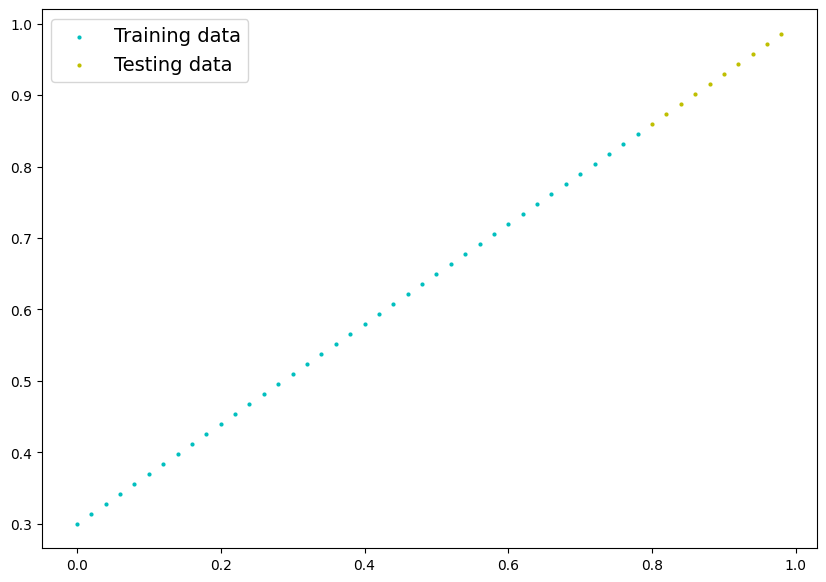

In [ ]:
plot_predictions();

## 2. Build Model

Our first PyTorch model!

This is very exciting... Let's do it!

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?

Through two main algorithms:
1. Gradient descent
2. Backpropagation

In [ ]:
# Create a linear regression model class
class LinearRegressionModel(nn.Module):# <- Almost everything in PyTorch inherhits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=False,
                                            dtype=torch.float))

    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=False,
                                         dtype=torch.float))

    # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias # this is the linear regression formula

In [ ]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

## Making predictions using torch.inference_mode()

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [ ]:
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [ ]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

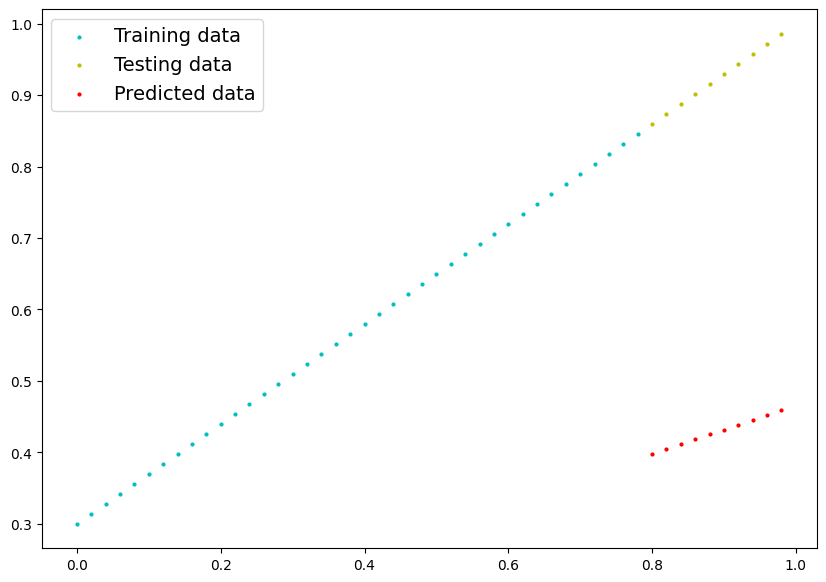

In [ ]:
plot_predictions(predictions=y_preds)

## 3. Train model
The whole idea of training is for a model to move from some "unknown" parameters to some "known" parameters.

One way to measure how poor or how wrong your models predictions are is to use a loss function.

**Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.

**Optimizer:** Takes into account the loss of a model and adjusts the model's parameters to improve the loss function.

And specifically we will use:
* Training loop
* Testing loop

In [ ]:
# Check out our model's parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup a optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # lr = learning rate

### Building a training loop (and a testing loop) in Pytorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through our model's 'forward()' functions) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through network to calculate the gradients of each of the parameters of our model with respect to the loss
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss

In [ ]:
# An epoch is one loop through the data...
epochs = 200

epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  print(f"Loss: {loss}")

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval() # turns off gradient tracking
  with torch.inference_mode():
    test_pred = model_0(X_test)

    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    print(model_0.state_dict())


Loss: 0.04167863354086876
Epoch: 0 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Loss: 0.04132963344454765
Loss: 0.04098063334822655
Loss: 0.04063162952661514
Loss: 0.040282636880874634
Loss: 0.039933640509843826
Loss: 0.03958464413881302
Loss: 0.03923564404249191
Loss: 0.03888664394617081
Loss: 0.0385376438498497
Loss: 0.03818932920694351
Epoch: 10 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788]))])
Loss: 0.03785243630409241
Loss: 0.0375034399330616
Loss: 0.037164121866226196
Loss: 0.03681822493672371
Loss: 0.03647511452436447
Loss: 0.03613303601741791
Loss: 0.03578609973192215
Loss: 0.03544783592224121
Loss: 0.035098835825920105
Loss: 0.03476089984178543
Epoch: 20 | Loss: 0.03476089984178543 | Test loss: 0.0805937647819519
OrderedDict([('weights', tensor([0.5288])), ('bias', tensor([0.3718]))])
Loss: 0.03441363573074

Text(0.5, 0, 'Epochs')

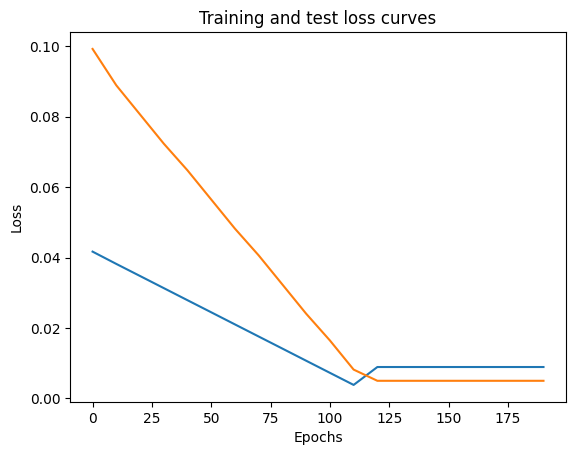

In [ ]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

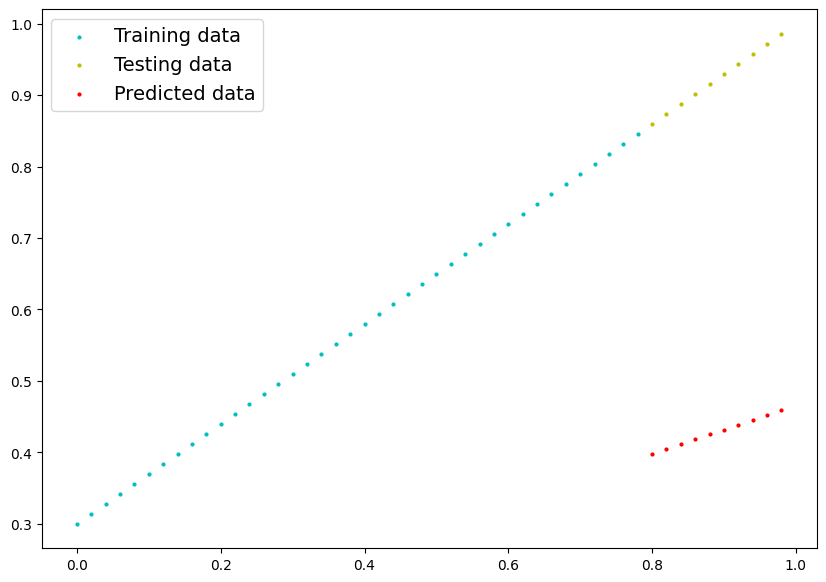

In [ ]:
plot_predictions(predictions=y_preds)

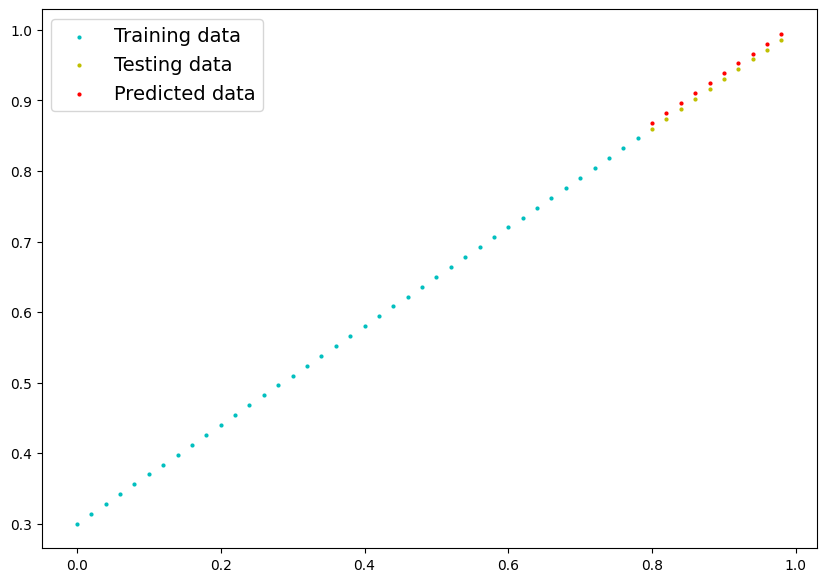

In [ ]:
plot_predictions(predictions=y_preds_new)

## Saving a model

There are thee main methods you should about for saving and loading models in PyTorch.

1. `torch.save()` - allows you save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to laod a model's saved state dictionary


In [ ]:
from pathlib import Path

# 1. Create a models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
ls -l models

total 4
-rw-r--r-- 1 root root 1680 Dec 22 02:29 01_pytorch_workflow_model_0.pth


##  Loading a PyTorch model

Since we saved our model's `state_dict()` rather than entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-37-ade34efd9648>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])